# Top Trendings do Twitter
**Objetivos:** Desenvolver uma aplica√ß√£o para monitorar o top trending e seu devido volume na rede social com o passar do tempo.

## Funcionalidades
**Requisitos funcionais obrigatorios**:
- [X] Utilizar a api do twitter para consumir o top trending e seu devido volume.
- [X] Armazenar o hist√≥rico das trendings em um banco de dados noSQL.
- [X] Utilizar alguma biblioteca gr√°fica para exibir os dados.

**Requisito funcional opcional**:
- [X] Utilizar IA para an√°lise de sentimento dos tweets referentes aos top trendings

### Insta√ß√£o das Bibliotecas
Para instalar as bibliotecas, ser√° usado um arquivo de texto com todas as depend√™ncias necessarias para este projeto funcionar.

In [ ]:
! python -m pip install -r requirements.txt

### Imports

In [21]:
import json
import pprint

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from modules import mongoDb
from modules import fileToDic as fd
from modules import apiKeys as api
from modules import mongoEnv
from modules import TwitterClient as tc
from modules import TwitterAuth as ta

## Funcionalidade 1: Consome o top trending e seu devido volume.

1. Abrir o arquivo `WOEID.txt` para poder ler os paises e seu identificadores.
2. Usando a fun√ß√£o `dictionary` que esta no arquivo `fileToDic`, o arquivo com os paises e seus respectivos valores ser√£o convertidos em dicionario.
3. Usando o dicionario `key` que est√° no arquivo `apiKeys`, o valor do `BEARER_TOKEN` no arquivo `.env` ser√° atribuido a varivel `bearer_token`. O Bearer Token ser√° usado na autentica√ß√£o da url que retorna os *trends* de um determinado pais.
4. Para buscar o trending de um determinado pais iremos usar a url: https://api.twitter.com/1.1/trends/place.json
5. Entretanto, devemos passar o parametro que no caso √© o id de um pais.

Fonte: https://developer.twitter.com/en/docs/twitter-api/v1/trends/trends-for-location/api-reference/get-trends-place

In [22]:
countries = {}
file = open("input/WOEID.txt")
countries = fd.dictionary(file, countries)

bearer_token = api.key['bearer_token']

search_url = "https://api.twitter.com/1.1/trends/place.json"

query_params = {'id': countries['BRAZIL'], 'exclude': 'hashtags'}

### Realizando a Pesquisa no Trend Tops
Dado um pais iremos procurar na url da Twitter API os top trending desse pais. No arquivo `WOEID.txt`, est√£o alguns pais para serem usado na pesquisa, contudo basta mudar a chave do dicionario `countries`, ex.: `countries['UNITED_STATES']`; `countries['AUSTRALIA']`; `countries['UNITED_KINGDOM']`; `countries['INDIA']`, ec.

A classe `TwitterAuth` recebe no construtor o `bearer_token` para poder colocar o seu valor no *Header Authorization* e depois a fun√ß√£o `connect_to_endpoint` realiza o `GET` na url dada, usando os param√™tros dado. Por fim, um `json` √© retornado 

In [23]:
oauth = ta.TwitterAuth(bearer_token)
top_trends = oauth.connect_to_endpoint(search_url, query_params)
print(top_trends)

200
[{'trends': [{'name': 'Permission to Dance', 'url': 'http://twitter.com/search?q=%22Permission+to+Dance%22', 'promoted_content': None, 'query': '%22Permission+to+Dance%22', 'tweet_volume': 273443}, {'name': 'QUE ORGULHO', 'url': 'http://twitter.com/search?q=%22QUE+ORGULHO%22', 'promoted_content': None, 'query': '%22QUE+ORGULHO%22', 'tweet_volume': 33111}, {'name': 'Pabllo Vittar', 'url': 'http://twitter.com/search?q=%22Pabllo+Vittar%22', 'promoted_content': None, 'query': '%22Pabllo+Vittar%22', 'tweet_volume': None}, {'name': 'Mete', 'url': 'http://twitter.com/search?q=Mete', 'promoted_content': None, 'query': 'Mete', 'tweet_volume': 31885}, {'name': 'Nova York', 'url': 'http://twitter.com/search?q=%22Nova+York%22', 'promoted_content': None, 'query': '%22Nova+York%22', 'tweet_volume': 30257}, {'name': 'Assembleia Geral da ONU', 'url': 'http://twitter.com/search?q=%22Assembleia+Geral+da+ONU%22', 'promoted_content': None, 'query': '%22Assembleia+Geral+da+ONU%22', 'tweet_volume': 2770

## Funcionalidade 2: Persistir os dados

1. criar conex√£o com o banco, neste projeto usando o MongoDb
2. Criar um banco chamado `tweets_db`
3. Criar uma cole√ß√£o chamada `top_trends`
4. Inserir a *response* nesta cole√ß√£o

Fonte: https://pymongo.readthedocs.io/en/stable/tutorial.html

### Variaveis de Ambiente

In [4]:
username = mongoEnv.key_mongo['mongo_username']
pwd = mongoEnv.key_mongo['mongo_password']

### Conex√£o com banco de dados

In [5]:
mongo_client = mongoDb.connect_to_mongo(username, pwd, '27017')

### Cria√ß√£o do Banco de Dados e a Cole√ß√£o

In [6]:
database = mongoDb.create_db(mongo_client, 'tweets_db')
collection = database['top_trends']

### Persistindo os dados encontrado no Json
Aqui eu decidi fazer um for para inserir um de cada vez, por√©m eu observei que s√≥ foi criado um unico documento, sendo que os top trendings √© uma lista com os 50 top trendings da data atual.

In [7]:
for trend in top_trends:
    trend_id = collection.insert_one(trend).inserted_id

### Procurando e Printando o primeiro documento

In [8]:
pprint.pprint(collection.find_one())

{'_id': ObjectId('6147193c5b64b01e186febf6'),
 'as_of': '2021-09-19T11:04:28Z',
 'created_at': '2021-09-15T02:00:22Z',
 'locations': [{'name': 'Brazil', 'woeid': 23424768}],
 'trends': [{'name': '#Calamidade',
             'promoted_content': None,
             'query': '%23Calamidade',
             'tweet_volume': 286336,
             'url': 'http://twitter.com/search?q=%23Calamidade'},
            {'name': 'Otis',
             'promoted_content': None,
             'query': 'Otis',
             'tweet_volume': 59009,
             'url': 'http://twitter.com/search?q=Otis'},
            {'name': 'Paulo Freire',
             'promoted_content': None,
             'query': '%22Paulo+Freire%22',
             'tweet_volume': 43627,
             'url': 'http://twitter.com/search?q=%22Paulo+Freire%22'},
            {'name': 'juliette no altas horas',
             'promoted_content': None,
             'query': '%22juliette+no+altas+horas%22',
             'tweet_volume': 84069,
             

             'url': 'http://twitter.com/search?q=kcon'},
            {'name': 'PROUD OF OLIVIA',
             'promoted_content': None,
             'query': '%22PROUD+OF+OLIVIA%22',
             'tweet_volume': None,
             'url': 'http://twitter.com/search?q=%22PROUD+OF+OLIVIA%22'},
            {'name': 'artemis',
             'promoted_content': None,
             'query': 'artemis',
             'tweet_volume': 15761,
             'url': 'http://twitter.com/search?q=artemis'},
            {'name': 'lucas fonseca',
             'promoted_content': None,
             'query': '%22lucas+fonseca%22',
             'tweet_volume': None,
             'url': 'http://twitter.com/search?q=%22lucas+fonseca%22'},
            {'name': 'Aline',
             'promoted_content': None,
             'query': 'Aline',
             'tweet_volume': 27678,
             'url': 'http://twitter.com/search?q=Aline'},
            {'name': 'Luiz Adriano',
             'promoted_content': None,
         

## Funcionalidade 3: Visualizando os Dados

1. Extrair as trends de um determinado pais. 
2. Tratar dos campos NaN.
2. Usar a biblioteca pandas para criar um Dataframe dos *trends*
3. Usar a biblioteca pandas para visualizar os dados em um gr√°fico
4. Usar a biblioteca matplot para visualizar os dados em um gr√°fico 

Fontes: [Analise Exploratoria - Projeto DIO](https://github.com/LeiteSS/analise_exploratoria); [Plot With Pandas: Python Data Visualization for Beginners](https://realpython.com/pandas-plot-python/); [Return Json List And Python Requests Library](https://stackoverflow.com/questions/51458509/return-json-list-and-python-requests-library); [How to Increase Image Size of Pandas Dataframe plot in Jupyter Notebook](https://stackoverflow.com/questions/51174691/how-to-increase-image-size-of-pandas-dataframe-plot-in-jupyter-notebook) 

### Extrai as Trends

In [10]:
trends = []
for item in top_trends:
    trends = item['trends']

### Dataframe com as Trends

In [11]:
df = pd.DataFrame(trends)

#### Comandos Importantes
Deixei anexados aqui alguns comando que foram usados depois de ter convertido a lista em Dataframe.
```py
df.head() # retorna as primeiras 5 linhas (por padr√£o) de um dataframe

df.shape # retorna a quantidade de linha e a quantidade de colunas de um dataframe

df.dtypes # retorna o tipo de cada coluna
```

### Mudando os Nomes dos Campos

In [12]:
df_trends = df.rename(
    columns={
        'name': 'Nome', 
        'url': 'URI', 
        'promoted_content': 'Patrocinado', 
        'query': 'Hashtag', 
        'tweet_volume': 'Volume'
    }
)

### Preenche os valores *Not A Number* com Zeros

In [13]:
df_trends["Volume"].fillna(0, inplace=True)

### Agrupando os nomes com o volume de tweets
Este projeto ir√° apresentar o volume de tweets usando uma determinado nome que uma determinada hashtag tem.

In [14]:
# Qual o volume de tweet usando o nome como indicador
df_trends.groupby("Nome")["Volume"].mean()

Nome
1 ANO GABE E FER                0.0
20 de Setembro                  0.0
Assembleia Geral da ONU     15683.0
Biden                      470380.0
Chandler                        0.0
Chanyeol                   283949.0
Chuseok                    430531.0
Dia 20                      26613.0
Emmys                      610177.0
Evergrande                  48638.0
Ga√∫cho                      23358.0
Gelo                        11523.0
Guga Chacra                     0.0
I May Destroy You           29500.0
JEON JUNGKOOK               51296.0
Joey                        22716.0
Jundia√≠                         0.0
Lamar                      159467.0
MEUS MENINOS                    0.0
Mare                        67686.0
Mete                        32402.0
Michaela Coel               71800.0
Na√ß√µes Unidas                   0.0
Nova Iorque                     0.0
Nova York                   28867.0
O Gambito da Rainha             0.0
PERMISSION TO DANCE         49027.0
Pabllo Vittar      

### Tra√ßando os Gr√°ficos

Text(0.5, 1.0, 'Top Trendings do Twitter')

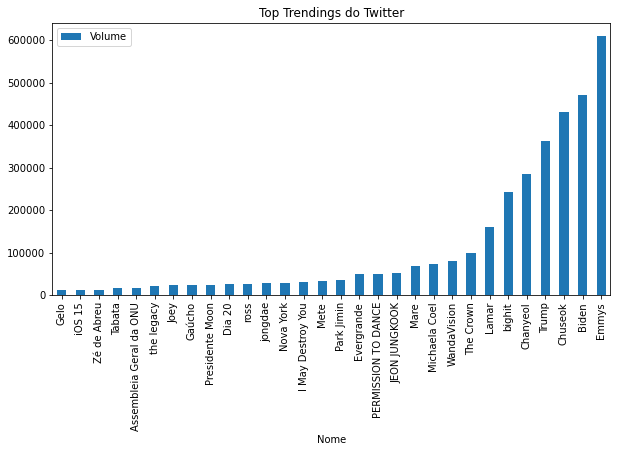

In [15]:
# Volume acima de 0
top = df_trends[df_trends["Volume"] > 0].sort_values("Volume")
top.plot(x="Nome", y=["Volume"], kind="bar", figsize=(10,5))
plt.title('Top Trendings do Twitter')

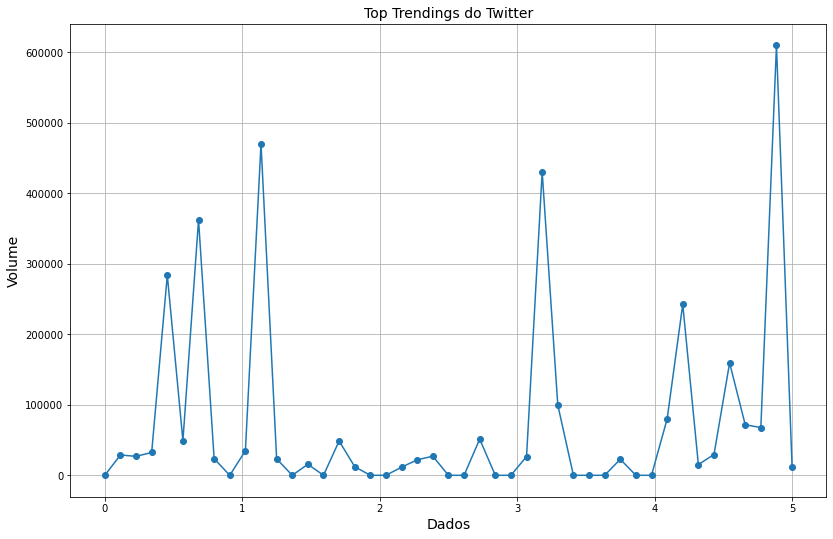

In [16]:
x = np.linspace(0.0, 5.0, 45)
fig, ax = plt.subplots(figsize=(15, 9))
fig.subplots_adjust(bottom=0.15, left=0.2)
plt.plot(x, df_trends["Volume"], marker='o')
plt.title('Top Trendings do Twitter', fontsize=14)
plt.xlabel('Dados', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.grid(True)
plt.show()

<AxesSubplot:xlabel='Nome'>

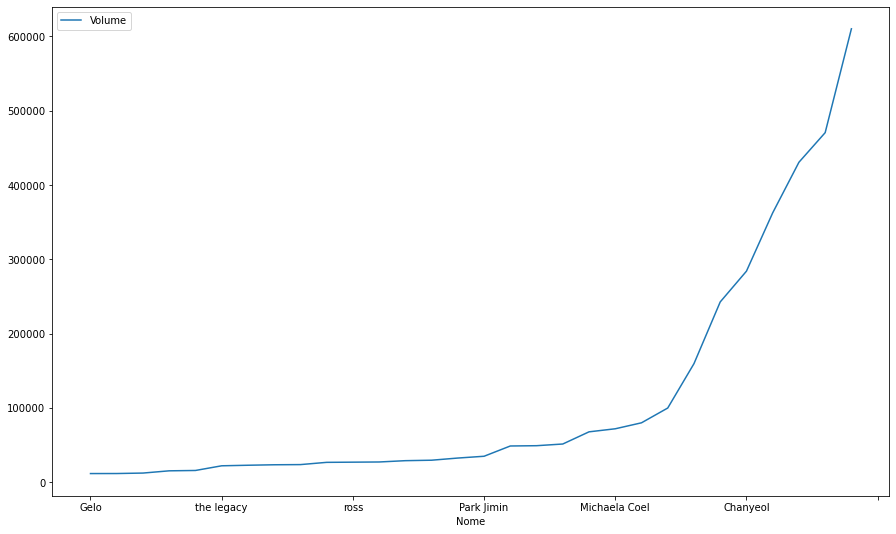

In [17]:
top = df_trends[df_trends["Volume"] > 0].sort_values("Volume")
top.plot(x="Nome", y="Volume", kind='line', figsize=(15,9))

## Funcionalidade 4: An√°lise de Sentimento
1. Usar o tweepy para obter os tweets.
2. Usar o textblob para analisar os tweets, afim de encontrar sentimentos.
3. Usar a lista de trends obtida na funcionalidade tr√™s para servir como param√™tro na fun√ß√£o que obtem os tweets.

### Twitter Client

In [18]:
twitter_client = tc.TwitterClient()

### An√°lise Usando o Dataframe
Para ser realizado a an√°lise de sentimento nos tweets, o la√ßo `for` e a fun√ß√£o `iterrows()` do `Dataframe` permite percorrer as linhas do `Dataframe` e atrav√©s disso, selecionar uma coluna, neste caso a coluna `Nome`, mas pode ser tamb√©m a coluna `Hashtag` pois no `json` obtido da *request* feita na **Twitter Api** essa coluna se chamava `query`. Pois bem, todos os tweets pegos usando a `query` escolhida s√£o guardadas em uma lista para serem analisadas usando a biblioteca Textblob, se h√° sentimentos positivos, neutros ou negativos. Descorberto, os sentimentos √© feito o calculo para descobrir a porcentagem de tweets que esse sentimento possui.

Al√©m de claro, retornar os tweets ao final.

Fontes: [Twitter Sentiment Analysis using Python](https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/) e [How to iterate over rows in a DataFrame in Pandas](https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas)

In [20]:
for index, row in df_trends.iterrows():
    print("O que est√° sendo comentado no top trendings: " + row['Nome'])
    tweets = twitter_client.get_tweets(query = row['Hashtag'], count = 200)
    
    positive_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positivo']
    
    print("Porcentagem de tweets positivos: {} %".format(100*len(positive_tweets)/len(tweets)))
    
    negatives_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negativo']
    
    print("Porcentagem de tweets negativos: {} %".format(100*len(negatives_tweets)/len(tweets)))
    
    print("Porcentagem de tweets neutros: {} % \
        ".format(100*(len(tweets) -(len( negatives_tweets )+len( positive_tweets)))/len(tweets)))
    
    print("\n\nTweets positivos:")
    for tweet in positive_tweets[:10]:
        print(tweet['text'])
        
    print("\n\nTweets negativos:")
    for tweet in negatives_tweets[:10]:
        print(tweet['text'])
    print("------------------------------------{}-----------------------------------------------------".format(row["Nome"]))

O que est√° sendo comentado no top trendings: Pabllo Vittar
Porcentagem de tweets positivos: 4.0 %
Porcentagem de tweets negativos: 4.0 %
Porcentagem de tweets neutros: 92.0 %         


Tweets positivos:
Hoje tem super bowl da Pabllo Vittar, √†s 17h, com patroc√≠nio da pepsi. https://t.co/D2aSLhllxD


Tweets negativos:
today pabllo vittar vai passar bad aah
------------------------------------Pabllo Vittar-----------------------------------------------------
O que est√° sendo comentado no top trendings: Nova York
Porcentagem de tweets positivos: 0.0 %
Porcentagem de tweets negativos: 2.0833333333333335 %
Porcentagem de tweets neutros: 97.91666666666667 %         


Tweets positivos:


Tweets negativos:
RT @carteiroreaca: Fake News! Se a not√≠cia de que Bolsonaro foi proibido de acessar locais fechados fosse verdade, o Presidente n√£o teria l‚Ä¶
------------------------------------Nova York-----------------------------------------------------
O que est√° sendo comentado no top trending

Porcentagem de tweets positivos: 26.923076923076923 %
Porcentagem de tweets negativos: 7.6923076923076925 %
Porcentagem de tweets neutros: 65.38461538461539 %         


Tweets positivos:
RT @ddaengswan: La cuenta que traduce de KR a ENG, menciono que el orden es el siguiente:

‚Äî Discurso de apertura del secretario General de‚Ä¶
RT @ARMYForce_Peru: üåø #BTSatUNGA | #OurPrideBTS üåø

‚Ä¢ Discurso de apertura del Secretario General de la ONU‚úÖ
Y del Presidente de la Asamblea‚Ä¶
RT @JIMINATION_SA: Jimin apareci√≥ durante la transmisi√≥n nacional de KTV sobre la asistencia del presidente Moon a la 76a Asamblea General‚Ä¶
RT @bestdisease: igual es important√≠simo lo que acaba de pasar porque el tema de este a√±o est√° apuntado a las nuevas generaciones y al inte‚Ä¶
RT @kiss_seven7: ‚Äî ODS Moment | Calendario

‚Ä¢ Discurso de apertura del Secretario General de la ONU
‚Ä¢ Discurso de apertura del presidente d‚Ä¶
RT @TETEXGIRL: Al parecer est√° ser√° el orden de apertura del 2o ODS 

 ‚Ü

Porcentagem de tweets positivos: 1.0416666666666667 %
Porcentagem de tweets negativos: 0.0 %
Porcentagem de tweets neutros: 98.95833333333333 %         


Tweets positivos:
@NORDESTEPATRIO1 Hahahaha Hahahaha Hahahaha Hahahaha‚Ä¶
S√©rio mesmo?
O calcinha apertada atochada no kool?
Ser√° que e‚Ä¶ https://t.co/0jQ5vGP7Ek


Tweets negativos:
------------------------------------Jundia√≠-----------------------------------------------------
O que est√° sendo comentado no top trendings: Evergrande
Porcentagem de tweets positivos: 33.76623376623377 %
Porcentagem de tweets negativos: 9.090909090909092 %
Porcentagem de tweets neutros: 57.142857142857146 %         


Tweets positivos:
RT @business: How far will Xi Jinping go with his crackdown on China‚Äôs real estate sector? The question has suddenly become an urgent one o‚Ä¶
And people are worried about this evergrande default being a catalyst for disaster LMAO 

We ain't seen nothing yet‚Ä¶ https://t.co/wgbN0N5nH7
RT @Barton_options: 4/ The pro

Porcentagem de tweets positivos: 0.0 %
Porcentagem de tweets negativos: 3.5714285714285716 %
Porcentagem de tweets neutros: 96.42857142857143 %         


Tweets positivos:


Tweets negativos:
Envergonhado porque Jail Bozo e seus asseclas n√£o entram em restaurantes de Nova Iorque?Vergonha mesmo √© ele ter si‚Ä¶ https://t.co/FPKQNG8Y1Q
------------------------------------Nova Iorque-----------------------------------------------------
O que est√° sendo comentado no top trendings: Chandler
Porcentagem de tweets positivos: 8.474576271186441 %
Porcentagem de tweets negativos: 5.084745762711864 %
Porcentagem de tweets neutros: 86.44067796610169 %         


Tweets positivos:
@smileand_nod PLSSS HES SO CUTE ü•∞
@moneymakamike7 @encinomandude @OldTakesExposed 1.) Peterson (how you liking your washed corner btw? You‚Äôre welcome‚Ä¶ https://t.co/nHxhtGOLC5
RT @TimelineCR7: Cristiano Ronaldo becomes the MOST goal scoring player after the age of 30 in the history of the Top 5 leagues:

 1- Cris

Porcentagem de tweets positivos: 0.0 %
Porcentagem de tweets negativos: 0.0 %
Porcentagem de tweets neutros: 100.0 %         


Tweets positivos:


Tweets negativos:
------------------------------------Na√ß√µes Unidas-----------------------------------------------------
O que est√° sendo comentado no top trendings: billie bossa
Porcentagem de tweets positivos: 20.689655172413794 %
Porcentagem de tweets negativos: 0.0 %
Porcentagem de tweets neutros: 79.3103448275862 %         


Tweets positivos:
RT @dataeilish: Life Is Beautiful - Setlist:

1- Bury A Friend.
2- You Should See Me In A Crown. 3- I Didn't Change My Number.
4- NDA.
5- T‚Ä¶
RT @InfoBillieBR: VENCEMOS! Billie Eilish est√° performando "Billie Bossa Nova" agora no festival Life Is Beautiful. https://t.co/WtG2mptuJM
RT @QGBillieEilish: YOU BETTER LOCK YOUR PHONE | Billie Eilish durante a performance de 'Billie Bossa Nova' no 'Life is Beautiful'. https:/‚Ä¶
Life Is Beautiful - Setlist:

1- Bury A Friend.
2- You Should See Me In

Porcentagem de tweets positivos: 50.0 %
Porcentagem de tweets negativos: 7.8125 %
Porcentagem de tweets neutros: 42.1875 %         


Tweets positivos:
RT @UNGeneva: Today at #UNGA in New York:

@BTS_twt will join Heads of State and Government in keeping the promise of the #GlobalGoals for‚Ä¶
RT @Palak_952: @bts_bighit they did great i'm so proud of them üò≠ https://t.co/QbiaMngRQP
@bts_bighit Thank you Bts, we're so proud of you @BTS_twt! Im so proud of you, thank you for being our voice and giving us hope
@bts_bighit we‚Äôre so proud of you :((
RT @VigilanteArtist: @bts_bighit #YouthToday Let's live on üí™üíú https://t.co/U8647RqRDM
@bts_bighit I'm super proud to be with you, guys did very well... I love you too much  üíú
@bts_bighit So proud of you! And love the NYC #PTD a great surprise üíúüíúüíúüíúüíúüíúüíú There's no-one like @BTS_twt
RT @MaherNasserUN: And here they are - Special Guest @bts_bighit take the stage at the @UN General Assembly Hall to support the #SDGMome

Porcentagem de tweets positivos: 58.13953488372093 %
Porcentagem de tweets negativos: 23.25581395348837 %
Porcentagem de tweets neutros: 18.6046511627907 %         


Tweets positivos:
RT @awards_watch: Michaela Coel is the first Black woman ever to win the writing for a limited series Emmy #Emmys https://t.co/Ix3oUlDJfT
RT @Phil_Lewis_: "I dedicate this award to every single survivor of sexual assault." Michaela Coel #Emmys2021 https://t.co/9VJzkWcFvy
RT @MJFINESSELOVER: Michaela Coel is a first-time Emmy Award winner!!!! #Emmys https://t.co/Nlv5YaHDxX
RT @nytimes: Michaela Coel has made history as the first Black woman to win at the #Emmys for limited series writing. It is her first Emmy‚Ä¶
RT @flyrebel: Michaela Coel winning an Emmy for the brilliant,‚ÄúI May Destroy You‚Äù while wearing CJR‚Ä¶..ü§åüèæüòò
RT @DionneGrant: "I dedicate this story to every single survivor of sexual assault" 

Michaela Coel, the creator, writer, and star of "I Ma‚Ä¶
@Izenberg__ @EstBlueprint @rafayno